In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [2]:
chexnet_weights="/kaggle/input/fyp2-dataset/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"

In [3]:
train=pd.read_csv("/kaggle/input/dataset8020/impression_train_final8020.csv")
test=pd.read_csv("/kaggle/input/dataset8020/impression_test_final8020.csv")

In [4]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights(chexnet_weights)

chexnet_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [5]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")   

In [6]:
image_folder = "/kaggle/input/fyp2-dataset/NLMCXR_png"
df_path = "/kaggle/input/fyp2-dataset/NLMCXR_reports/NLMCXR_reports/ecgen-radiology"

In [7]:
print(train.shape) 
print(test.shape)

(4404, 6)
(764, 5)


In [8]:
train.head()

Unnamed: 0                             impression  \
0           0  no acute cardiopulmonary abnormality    
1           1                      no acute disease    
2           2  no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormality    
4           4  no acute cardiopulmonary abnormality    

                               image_1                              image_2  \
0  NLMCXR_png/CXR2401_IM-0950-1001.png  NLMCXR_png/CXR2401_IM-0950-2001.png   
1   NLMCXR_png/CXR251_IM-1032-1001.png   NLMCXR_png/CXR251_IM-1032-3001.png   
2   NLMCXR_png/CXR211_IM-0740-1001.png   NLMCXR_png/CXR211_IM-0740-1002.png   
3  NLMCXR_png/CXR2391_IM-0944-1001.png  NLMCXR_png/CXR2391_IM-0944-2001.png   
4  NLMCXR_png/CXR1933_IM-0604-1001.png  NLMCXR_png/CXR1933_IM-0604-1002.png   

   impression_counts                                   impression_final  
0                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
1                110                      <SOS> no acute disease  <EOS>  
2                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
3                411  <SOS> no acute cardiopulmonary abnormality  <EOS>  
4                411  <SOS> no acute cardiopulmonary abnormality  <EOS>

In [9]:
test.head()

Unnamed: 0                               impression  \
0           0        no acute cardiopulmonary disease    
1           1          no acute pulmonary abnormality    
2           2    no acute cardiopulmonary abnormality    
3           3  no acute cardiopulmonary abnormalities    
4           4        no acute cardiopulmonary process    

                               image_1                              image_2  \
0  NLMCXR_png/CXR3937_IM-2008-1001.png  NLMCXR_png/CXR3937_IM-2008-2001.png   
1   NLMCXR_png/CXR333_IM-1594-1001.png   NLMCXR_png/CXR333_IM-1594-2001.png   
2   NLMCXR_png/CXR529_IM-2137-1001.png   NLMCXR_png/CXR529_IM-2137-2001.png   
3   NLMCXR_png/CXR331_IM-1584-1001.png   NLMCXR_png/CXR331_IM-1584-2001.png   
4  NLMCXR_png/CXR2214_IM-0819-1002.png  NLMCXR_png/CXR2214_IM-0819-1002.png   

   impression_counts  
0                160  
1                 29  
2                411  
3                136  
4                 89

In [10]:
image_1= Input(shape=(224,224,3),name="image_1_features")
image_2= Input(shape=(224,224,3),name="image_2_features")
image_1_out=final_chexnet_model(image_1)
image_2_out=final_chexnet_model(image_2)
conc=concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
feature_extraction_model=Model(inputs=[image_1,image_2],outputs=conc)
feature_extraction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_2_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Chexnet_model (Functional)     (None, 1024)         7037504     ['image_1_features[0][0]',       
                                                                  'image_2_features[0][0]'] 

In [11]:
tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True) 

In [12]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature

In [13]:
root_path = "/kaggle/input/fyp2-dataset/NLMCXR_png/"

In [14]:
train_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/train_image_features8020 (1).npz")
train_features=train_features['arr_0']
test_features=np.load("/kaggle/input/chexrayimpressionimgfeature80201dim/test_image_features8020 (1).npz")
test_features=test_features['arr_0']

In [15]:
print(train_features.shape)
print(test_features.shape) 

(4404, 1, 2048)
(764, 1, 2048)


In [16]:
k=100
print(test_features[k])
one=test.iloc[k]["image_1"] 
two=test.iloc[k]["image_2"]

print(image_feature_extraction(root_path+one,root_path+two))  

[[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]]
tf.Tensor([[0.         0.00191964 0.0013159  ... 0.81735057 0.8349675  0.6745591 ]], shape=(1, 2048), dtype=float32)


In [17]:
#Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word

train_report=["<sos> "+text+" <eos>" for text in train["impression"].values]
train_report_in=["<sos> "+text for text in train["impression"].values]
train_report_out=[text+" <eos>" for text in train["impression"].values]

test_report=["<sos> " +text+" <eos>" for text in test["impression"].values]
test_report_in=["<sos> " +text for text in test["impression"].values]
test_report_out=[text+" <eos>" for text in test["impression"].values]  

In [18]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])

<sos> no acute cardiopulmonary abnormality 
****************************************************************************************************
no acute cardiopulmonary abnormality  <eos>


In [19]:
bs=20
max_len=22

In [20]:
# tokenizing and padding

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [21]:
import torch
from transformers import AutoTokenizer, AutoModel

In [22]:
# Load Bio_ClinicalBERT model and tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
token.word_index

{'<sos>': 1,
 '<eos>': 2,
 'no': 3,
 'the': 4,
 'acute': 5,
 'right': 6,
 'and': 7,
 'left': 8,
 'disease': 9,
 'with': 10,
 'normal': 11,
 'cardiopulmonary': 12,
 'pulmonary': 13,
 'lung': 14,
 'heart': 15,
 'lungs': 16,
 'pleural': 17,
 'size': 18,
 'clear': 19,
 'chest': 20,
 'atelectasis': 21,
 'stable': 22,
 'are': 23,
 'abnormality': 24,
 'effusion': 25,
 'cardiomegaly': 26,
 'airspace': 27,
 'lobe': 28,
 'may': 29,
 'mild': 30,
 'effusions': 31,
 'edema': 32,
 'mediastinal': 33,
 'findings': 34,
 'upper': 35,
 'for': 36,
 'without': 37,
 'pneumonia': 38,
 'evidence': 39,
 'focal': 40,
 'bilateral': 41,
 'within': 42,
 'changes': 43,
 'opacities': 44,
 'lower': 45,
 'small': 46,
 'limits': 47,
 'interstitial': 48,
 'pneumothorax': 49,
 'this': 50,
 'seen': 51,
 'consolidation': 52,
 'base': 53,
 'active': 54,
 'infiltrate': 55,
 'scarring': 56,
 'opacity': 57,
 'basilar': 58,
 'low': 59,
 'process': 60,
 'represent': 61,
 'volumes': 62,
 'identified': 63,
 'there': 64,
 'calcifie

In [24]:
words_array = [None] * (vocab_size )
len(words_array)

1306

In [25]:
# Iterate over the word-index dictionary and assign each word to the corresponding index in the array
for word, index in token.word_index.items():
    words_array[index] = word

In [26]:
words_array[10]

'with'

In [27]:
# Now you have the words in the same order as the indices in the `words_array`

# Convert the words_array to a list of strings
word_list = list(filter(None, words_array))

In [28]:
word_list[10]

'normal'

In [29]:
# Now you can use the word_list as needed, such as passing it to the tokenizer
tokens = tokenizer(word_list, padding=True, truncation=True, return_tensors="pt")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [30]:
# Get the token embeddings from Bio_ClinicalBERT
with torch.no_grad():
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state

# Convert the embeddings to a numpy array
embedding_matrix = embeddings.numpy()


In [31]:
len(embeddings[0])

9

In [32]:

# Calculate the average embedding for each token
average_embeddings = np.mean(embedding_matrix, axis=1)

In [33]:
average_embeddings.shape

(1305, 768)

In [34]:
enc_units=512
embedding_dim=768
dec_units=512
att_units=512

In [35]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GRU, AdditiveAttention, Concatenate
from tensorflow.keras.models import Model

In [36]:
embedding_matrix.shape

(1305, 9, 768)

In [37]:
vocab_size=len(token.word_index)
vocab_size

1305

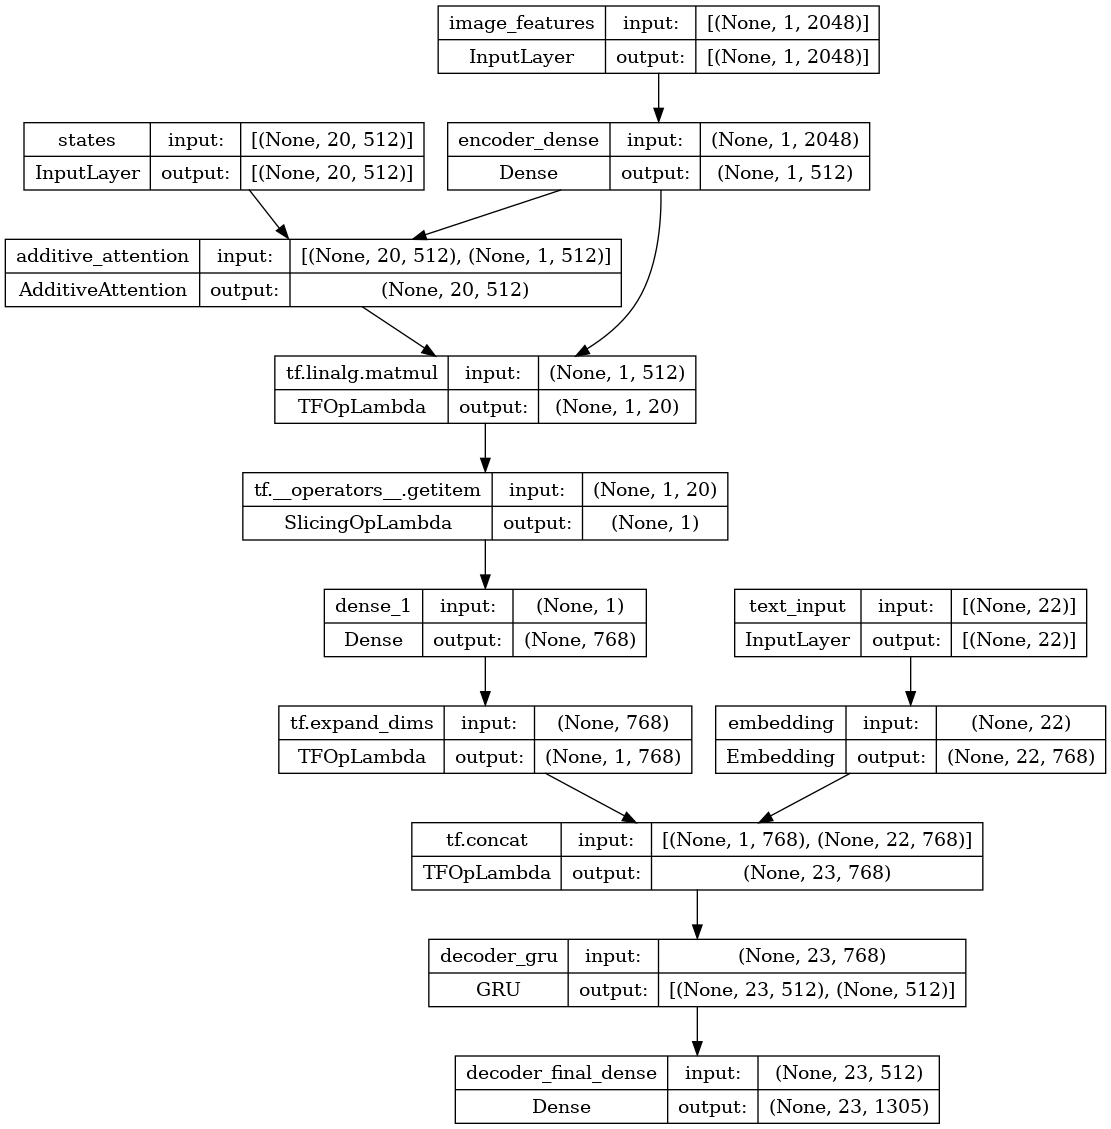

In [38]:

# Define the model inputs
input_img = Input(shape=(1, 2048), name="image_features")
input_txt = Input(shape=(max_len,), name="text_input")
state_h = Input(shape=(bs, enc_units), name="states")

# Encoder model
en_out = Dense(enc_units, activation="relu", name="encoder_dense")(input_img)
enc_out = Dropout(0.2)(en_out)

# Decoder model with attention
emb_out = Embedding(vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True,
                    trainable=False, weights=[average_embeddings])(input_txt)
weights = AdditiveAttention()([state_h, en_out])
context_vector = tf.matmul(en_out, weights, transpose_b=True)[:, :, 0]
context_vector = Dense(embedding_dim)(context_vector)
result = tf.concat([tf.expand_dims(context_vector, axis=1), emb_out], axis=1)
gru_out, state = GRU(dec_units, return_sequences=True, return_state=True, name="decoder_gru")(result)
out = Dense(vocab_size, name="decoder_final_dense")(gru_out)

en_de = Model(inputs=[input_txt, input_img, state_h], outputs=out)

plot_model(en_de, show_shapes=True, show_layer_names=True)

In [39]:
#encoder model

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.2)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      hidden=tf.zeros((batch_size,self.units))
      
      return hidden 

In [40]:
# Attention class

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]


    return (context_vector,alphas)
        

In [41]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[average_embeddings])

    self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 


  def call(self,input_to_decoder, encoder_output, state_h):
    
    embed=self.embedding(input_to_decoder)
    
    context_vector,alpha=self.attention(state_h,encoder_output)
    
    context_vector=self.dense_2(context_vector) 
    
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,decoder_state_1=self.gru(result,initial_state=state_h)
    out=tf.reshape(output,(-1,output.shape[-1]))

    out=tf.keras.layers.Dropout(0.2)(out)
    
    dense_op=self.dense(out)
    
    return dense_op,decoder_state_1,alpha

In [42]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1):
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

In [43]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
 
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h)
      
        return output

In [44]:
optimizer = tf.keras.optimizers.Adam(1e-3)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_ 

In [45]:
model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)
model.compile(optimizer=optimizer,loss=loss_function,metrics=['accuracy'])

In [46]:
model.fit([train_features[:4060],train_padded_inp[:4060]],train_padded_out[:4060],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]), batch_size=bs,epochs=20)

Epoch 1/20
203/203 [==============================] - 53s 95ms/step - loss: 2.8106 - accuracy: 0.5160 - val_loss: 1.2784 - val_accuracy: 0.7708
Epoch 2/20
203/203 [==============================] - 12s 59ms/step - loss: 1.9050 - accuracy: 0.6175 - val_loss: 1.1894 - val_accuracy: 0.7794
Epoch 3/20
203/203 [==============================] - 12s 58ms/step - loss: 1.3673 - accuracy: 0.7017 - val_loss: 1.1940 - val_accuracy: 0.7786
Epoch 4/20
203/203 [==============================] - 12s 60ms/step - loss: 0.9780 - accuracy: 0.7832 - val_loss: 1.2093 - val_accuracy: 0.7776
Epoch 5/20
203/203 [==============================] - 13s 62ms/step - loss: 0.7243 - accuracy: 0.8402 - val_loss: 1.2607 - val_accuracy: 0.7715
Epoch 6/20
203/203 [==============================] - 12s 59ms/step - loss: 0.5673 - accuracy: 0.8742 - val_loss: 1.2949 - val_accuracy: 0.7524
Epoch 7/20
203/203 [==============================] - 12s 60ms/step - loss: 0.4815 - accuracy: 0.8926 - val_loss: 1.2966 - val_accuracy:

In [47]:
model.save_weights('/kaggle/working/chexImpressionBiobertATT.h5')

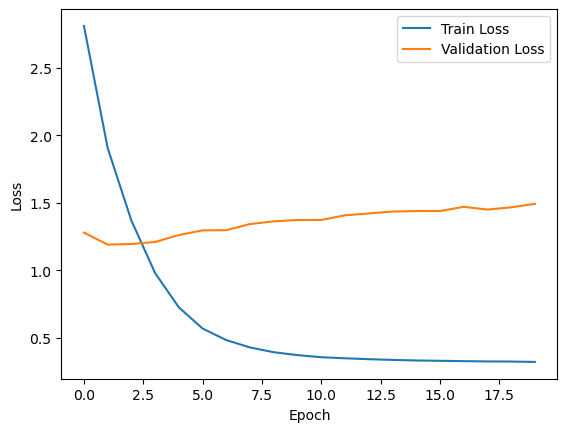

In [49]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plot the learning curve using the train_loss and val_loss data
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [51]:
def take_second(elem):
    return elem[1]

In [52]:
import time

In [55]:
def evaluate(image1,image2):
  
  curr=tf.constant([[token.word_index['<sos>']]])
  # curr= np.array([token.word_index['<sos>']]).reshape(1,1)

  features=image_feature_extraction(image1,image2)

  h= tf.zeros((1,enc_units))

  en_output= model.layers[0].predict(features)
  
  pred=[]
  for i in range(max_len):
    out,h,alpha=model.layers[1].onestep(curr,en_output,h)
    
    k=tf.argmax(out[0])

    curr=np.reshape(k,(1,1))
    
    pred.append(token.index_word[curr[0][0]])
    if token.index_word[curr[0][0]]=="<eos>":
      break
 
  predi="<sos> "               
  for j in pred:
    predi+=j+" "
 
  
  return predi

In [53]:
!pip install pycocoevalcap
!pip install rouge
!pip install -U nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93512 sha256=cc0fc05fc730ef4c20dd886a374bc77e485f506df0fd195e50544bc29d1841ad
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadloc

True

In [56]:
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
import nltk
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [57]:
def get_rouge(reference, prediction, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(reference, prediction)
    return rouge_scores[0][variant][measure]

In [58]:
def get_meteor(reference, prediction):
    hypothesis = [reference.split()]
    reference = prediction.split()
    return meteor_score(hypothesis, reference)

In [59]:
pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=fad9b395d78cd8279e04776a50a89ffde1028b8d8843cfc4655c5dbc77bc08f9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [60]:
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from rouge_score import scoring
def get_rouge_l(reference, prediction):
    reference_tokens = word_tokenize(reference)
    prediction_tokens = word_tokenize(prediction)
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(' '.join(reference_tokens), ' '.join(prediction_tokens))
    rouge_l_fscore = scores['rougeL'].fmeasure
    return rouge_l_fscore

In [61]:
def get_scores(reference,prediction):
    scores = dict()
    for k, v in get_bleu(reference, prediction).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(reference, prediction)
    scores["meteor"] = get_meteor(reference, prediction);
    # vale, arr = get_cider(query, groundtruth)
    return scores

In [62]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = bleu.sentence_bleu(reference,prediction,weights = (1,0,0,0))
  bleu2 = bleu.sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = bleu.sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = bleu.sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [63]:
root_path = "/kaggle/input/fyp2-dataset/NLMCXR_png/"

In [64]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [65]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/s

In [66]:
import random 
index=range(0,test.shape[0])
b1=0
b2=0
b3=0
b4=0
rouge_all = 0
meteor_all = 0
rouge_l_all=0

blue_top_five = []
blue_min_five = []

rouge_top_five = []
rouge_min_five = []

rouge_l_top_five = []
rouge_l_min_five = []

meteor_top_five = []
meteor_min_five = []

results=[]
start1=time.time()
for i in index:
  print(i)
  img1=root_path+test.iloc[i]["image_1"]
  img2=root_path+test.iloc[i]["image_2"]
  
  result=evaluate(img1,img2) 
  actual=test_report[i]
  img_blue = get_bleu(actual,result)
  rouge = get_rouge(actual,result)
  meteor = get_meteor(actual,result)
  rouge_l = get_rouge_l(actual,result)

  b1+=img_blue[0]
  b2+=img_blue[1]
  b3+=img_blue[2]
  b4+=img_blue[3]

  rouge_all += rouge
  rouge_l_all += rouge_l
  meteor_all += meteor
  
  results.append({
    'Index':i,
    'Image1': img1,
    'Image2': img2,
    'Result': result,
    'Actual': actual,
    'BLEU1': b1,
    'BLEU2': b2,
    'BLEU3': b3,
    'BLEU4': b4,
    'ROUGE': rouge,
    'METEOR': meteor,
    'ROUGE-L': rouge_l
    })
  if len(blue_top_five) < 5:
      blue_top_five.append({"img_blue": img_blue, "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      blue_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
      rouge_l_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      

      meteor_top_five.append({"img_blue": img_blue, "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
      
  else:
    if img_blue[3] > min(entry["img_blue"][3] for entry in blue_top_five):
        min_index = min(range(len(blue_top_five)), key=lambda i: blue_top_five[i]["img_blue"][3])
        blue_top_five.pop(min_index)
        blue_top_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if img_blue[3] < max(entry["img_blue"][3] for entry in blue_min_five):
        max_index = max(range(len(blue_top_five)), key=lambda i: blue_min_five[i]["img_blue"][3])
        blue_min_five.pop(max_index)
        blue_min_five.append({"img_blue": img_blue,  "rouge": rouge , "rouge_l": rouge_l ,"meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge > min(entry["rouge"] for entry in rouge_top_five):
        min_index = min(range(len(rouge_top_five)), key=lambda i: rouge_top_five[i]["rouge"])
        rouge_top_five.pop(min_index)
        rouge_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge < max(entry["rouge"] for entry in rouge_min_five):
        max_index = max(range(len(rouge_top_five)), key=lambda i: rouge_min_five[i]["rouge"])
        rouge_min_five.pop(max_index)
        rouge_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

    if rouge_l > min(entry["rouge_l"] for entry in rouge_l_top_five):
        min_index = min(range(len(rouge_l_top_five)), key=lambda i: rouge_l_top_five[i]["rouge_l"])
        rouge_l_top_five.pop(min_index)
        rouge_l_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if rouge_l < max(entry["rouge_l"] for entry in rouge_l_min_five):
        max_index = max(range(len(rouge_l_top_five)), key=lambda i: rouge_l_min_five[i]["rouge_l"])
        rouge_l_min_five.pop(max_index)
        rouge_l_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})




    if meteor > min(entry["meteor"] for entry in meteor_top_five):
        min_index = min(range(len(meteor_top_five)), key=lambda i: meteor_top_five[i]["meteor"])
        meteor_top_five.pop(min_index)
        meteor_top_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})
    if meteor < max(entry["meteor"] for entry in meteor_min_five):
        max_index = max(range(len(meteor_top_five)), key=lambda i: meteor_min_five[i]["meteor"])
        meteor_min_five.pop(max_index)
        meteor_min_five.append({"img_blue": img_blue,  "rouge": rouge ,"rouge_l": rouge_l , "meteor" : meteor, "img1": img1, "img2": img2, "actual": actual, "generated": result})

end1=time.time() 
print("average bleu score on the test data is ",b1/test.shape[0],b2/test.shape[0],b3/test.shape[0],b4/test.shape[0])
print("average rouge score on the test data is ",rouge_all/test.shape[0])
print("average rouge_l score on the test data is ",rouge_l_all/test.shape[0])
print("average meteor score on the test data is ",meteor_all/test.shape[0])

print('the average time taken for the evaluation is ',(end1-start1)/test.shape[0])

df = pd.DataFrame(results)
df.to_csv('/kaggle/working/results.csv')

0
1/1 [==============================] - 0s 97ms/step
1
1/1 [==============================] - 0s 19ms/step
2
1/1 [==============================] - 0s 21ms/step
3
1/1 [==============================] - 0s 20ms/step
4
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 20ms/step
6
1/1 [==============================] - 0s 18ms/step
7
1/1 [==============================] - 0s 22ms/step
8
1/1 [==============================] - 0s 22ms/step
9
1/1 [==============================] - 0s 19ms/step
10
1/1 [==============================] - 0s 19ms/step
11
1/1 [==============================] - 0s 20ms/step
12
1/1 [==============================] - 0s 34ms/step
13
1/1 [==============================] - 0s 29ms/step
14
1/1 [==============================] - 0s 19ms/step
15
1/1 [==============================] - 0s 20ms/step
16
1/1 [==============================] - 0s 20ms/step
17
1/1 [==============================] - 0s 25ms/step
18
1/1 [============

In [67]:
blue_top_five = sorted(blue_top_five, key=lambda x: x['img_blue'][3], reverse=True)
blue_min_five = sorted(blue_min_five, key=lambda x: x['img_blue'][3], reverse=False)

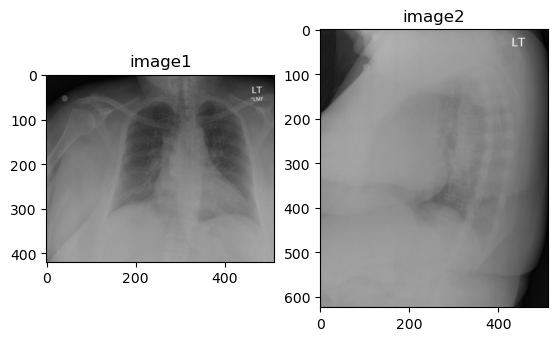

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR856_IM-2377-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR856_IM-2377-2001.png
blue:  (0.42857142857142855, 0.6546536707079771, 0.7560798445254401, 0.8091067115702212)
rouge:  0.33333332847222225
rouge_l:  0.3333333333333333
meteor:  0.28846153846153844
ACTUAL REPORT:  <sos> stable mild cardiomegaly no evidence active cardiopulmonary disease  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1595_IM-0386-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1595_IM-0386-2001.png
blue:  (0.3571428571428572, 0.5976143046671969, 0.7119309108013355, 0.7730551756939454)
rouge:  0.3076923027218935
rouge_l:  0.30769230769230765
meteor:  0.20491803278688522
ACTUAL REPORT:  <sos> persistent cardiomegaly right midlung scar no visible acute failure pneumonia  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


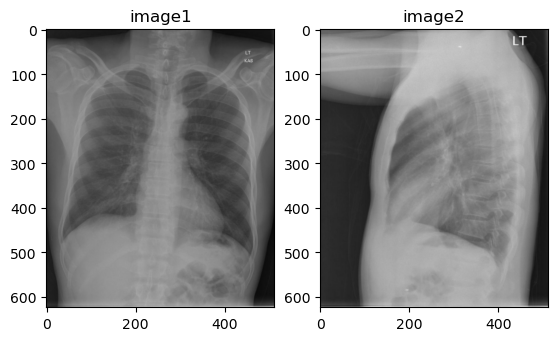

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1378_IM-0242-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1378_IM-0242-2001.png
blue:  (0.2857142857142857, 0.5345224838248488, 0.6613898798842307, 0.7311104457090247)
rouge:  0.3999999958
rouge_l:  0.4
meteor:  0.29411764705882354
ACTUAL REPORT:  <sos> negative for acute abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


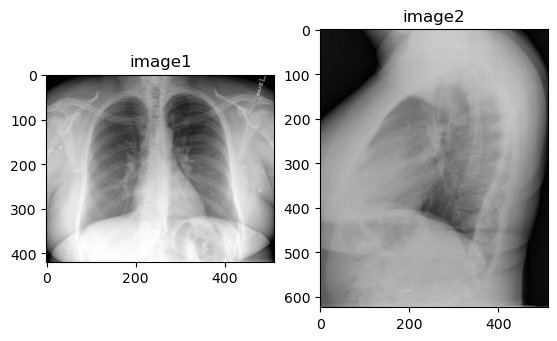

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3224_IM-1524-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3224_IM-1524-2001.png
blue:  (0.2857142857142857, 0.5345224838248488, 0.6613898798842307, 0.7311104457090247)
rouge:  0.3999999958
rouge_l:  0.4
meteor:  0.29411764705882354
ACTUAL REPORT:  <sos> negative for acute abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1830_IM-0537-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1830_IM-0537-2001.png
blue:  (0.2857142857142857, 0.5345224838248488, 0.6613898798842307, 0.7311104457090247)
rouge:  0.3999999958
rouge_l:  0.4
meteor:  0.29411764705882354
ACTUAL REPORT:  <sos> negative for acute abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [68]:
for i in range(5):
    i1 = cv2.imread(blue_top_five[i]["img1"])
    i2 = cv2.imread(blue_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_top_five[i]["img1"]) 
    print("img2: ", blue_top_five[i]["img2"]) 

    print("blue: ", blue_top_five[i]["img_blue"]) 
    print("rouge: ", blue_top_five[i]["rouge"]) 
    print("rouge_l: ", blue_top_five[i]["rouge_l"]) 
    print("meteor: ", blue_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", blue_top_five[i]["actual"])
    print("GENERATED REPORT: ", blue_top_five[i]["generated"])
    print("*"*100)

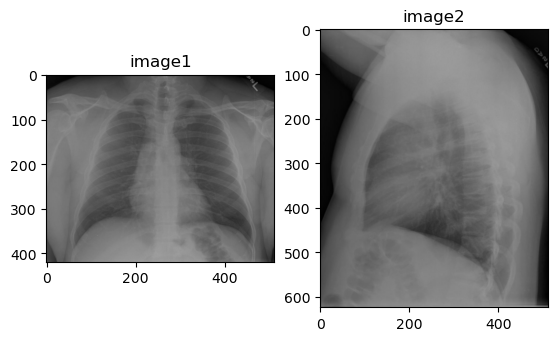

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR529_IM-2137-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR529_IM-2137-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


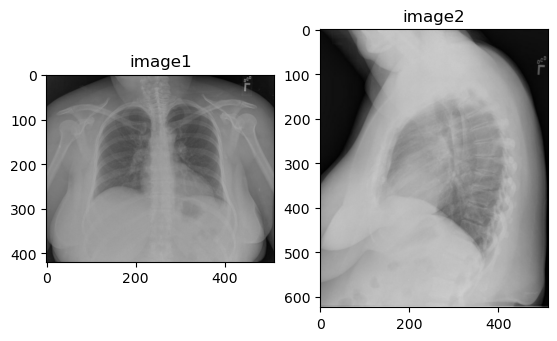

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1510_IM-0331-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1510_IM-0331-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


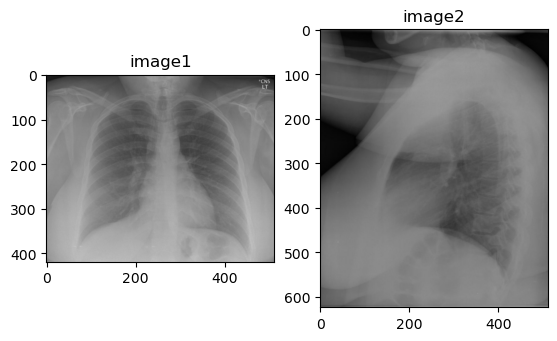

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1109_IM-0076-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1109_IM-0076-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


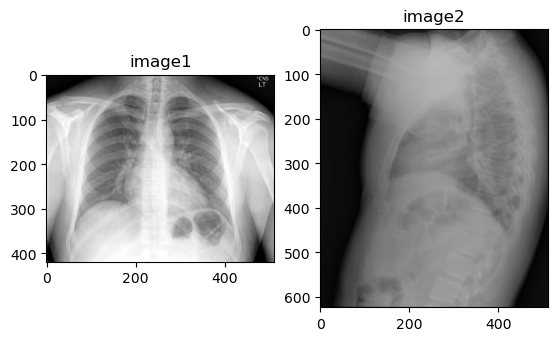

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1987_IM-0644-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1987_IM-0644-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


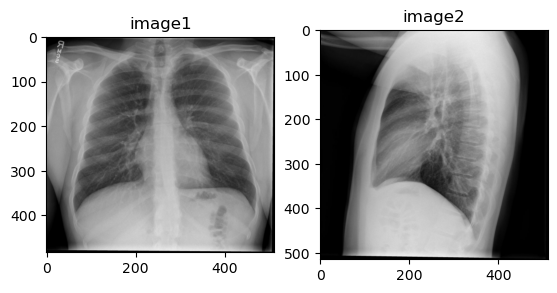

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1788_IM-0513-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1788_IM-0513-1002.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [69]:
for i in range(5):
    i1 = cv2.imread(rouge_top_five[i]["img1"])
    i2 = cv2.imread(rouge_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_top_five[i]["img1"]) 
    print("img2: ", rouge_top_five[i]["img2"]) 
    print("blue: ", rouge_top_five[i]["img_blue"]) 
    print("rouge: ", rouge_top_five[i]["rouge"]) 
    print("rouge_l: ", rouge_top_five[i]["rouge_l"]) 
    print("meteor: ", rouge_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", rouge_top_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_top_five[i]["generated"])
    print("*"*100)

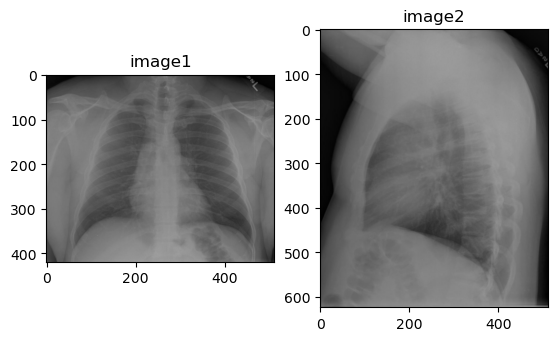

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR529_IM-2137-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR529_IM-2137-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


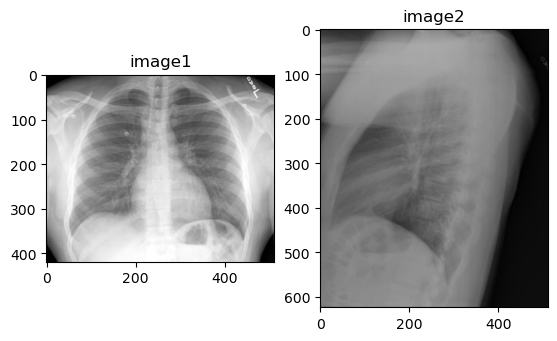

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-2001.png
blue:  (0.3571428571428572, 0.2870846258816073, 0.24293866735461883, 0.18798317647335086)
rouge:  0.49999999580000004
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


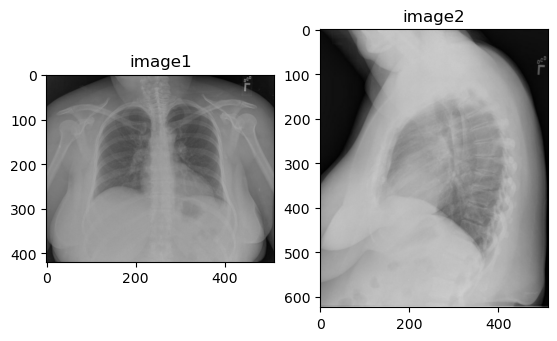

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1510_IM-0331-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1510_IM-0331-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


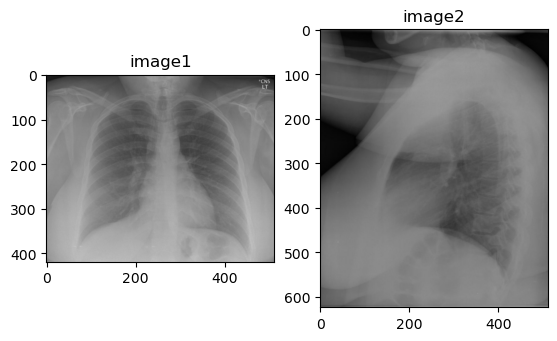

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1109_IM-0076-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1109_IM-0076-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


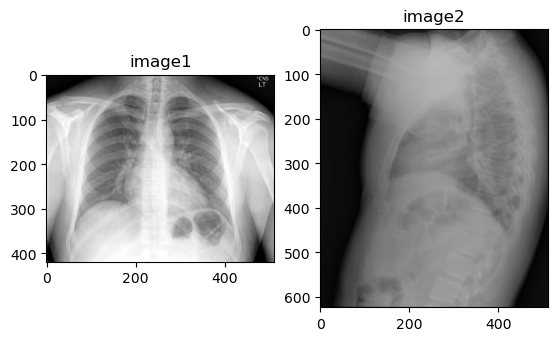

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1987_IM-0644-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1987_IM-0644-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [70]:
for i in range(5):
    i1 = cv2.imread(meteor_top_five[i]["img1"])
    i2 = cv2.imread(meteor_top_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_top_five[i]["img1"]) 
    print("img2: ", meteor_top_five[i]["img2"]) 
    print("blue: ", meteor_top_five[i]["img_blue"]) 
    print("rouge: ", meteor_top_five[i]["rouge"]) 
    print("rouge_l: ", meteor_top_five[i]["rouge_l"]) 
    print("meteor: ", meteor_top_five[i]["meteor"]) 
    print("ACTUAL REPORT: ", meteor_top_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_top_five[i]["generated"])
    print("*"*100)

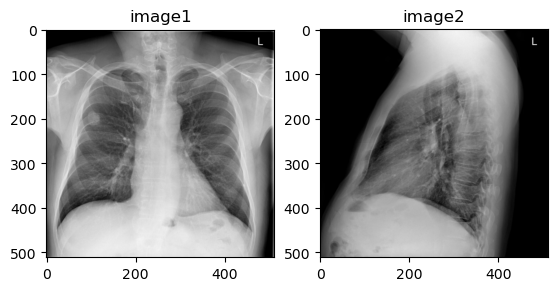

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1944_IM-0613-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1944_IM-0613-2001.png
blue:  (0.02157965463072629, 0.014660488405886076, 0.011716378198907884, 0.00882521873440124)
rouge:  0.17391304024364634
rouge_l:  0.16666666666666663
meteor:  0.13103428171641793
ACTUAL REPORT:  <sos> calcific density measuring approximately projecting over right upper lung seen well view only this may represent residua healed rib fracture possibly osteocartilaginous lesion conceivably granuloma which difficult see the lateral view this could followed months confirm stability azygos fissure incidentally noted lungs overall well expanded and clear mediastinal contour normal limits no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
***********************************************

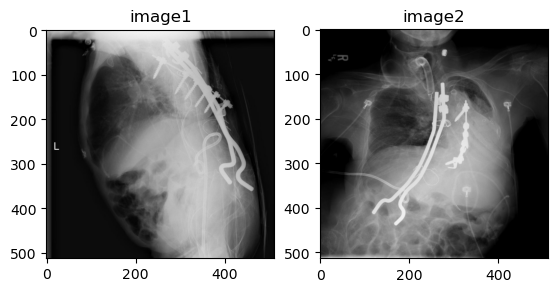

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-9001.png
blue:  (0.003924779761871609, 0.00847849331168295, 0.011016657168541341, 0.01246150158758297)
rouge:  0.08450703908748278
rouge_l:  0.07142857142857142
meteor:  0.023291925465838508
ACTUAL REPORT:  <sos> displacement fusion the lateral view with distal tip closely approximating the skin surface with change alignment since the previous exam severe scoliosis tracheostomy tube left picc tip the right hemithorax the expected location the right subclavian vein repositioning recommended heart size within normal limits for technique retrocardiac opacity due part atelectasis with small left hemithorax bronchovascular crowding without typical findings pulmonary edema shunt tubing and right nephrostomy tube  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atheroscleroti

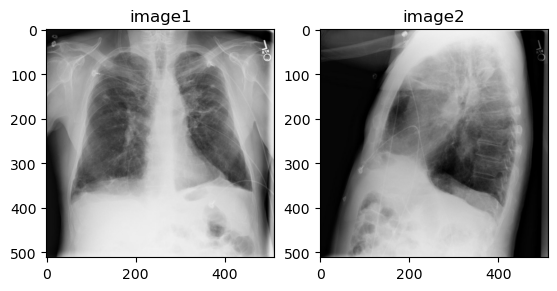

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-2001.png
blue:  (0.00602478423192258, 0.013015021456982204, 0.016911262905074057, 0.019129190126873696)
rouge:  0.09230768892781077
rouge_l:  0.0759493670886076
meteor:  0.02542372881355932
ACTUAL REPORT:  <sos> severe emphysema irregular pleural parenchymal opacity left upper lobe this may irregular pleural parenchymal scarring however recommend comparison with more remote outside imaging available determine long term stability none are available recommend short term months evaluation coronal and sagittal reformatted images from the outside study would also helpful these were not available the outside institution malignancy cannot confidently excluded the available images  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
***********

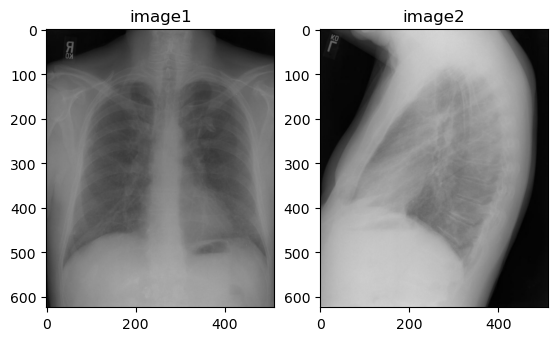

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3934_IM-2005-0001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3934_IM-2005-2001.png
blue:  (0.016409319790747813, 0.008514377957235711, 0.016293517906534057, 0.022113412841949842)
rouge:  0.1355932167193336
rouge_l:  0.11764705882352941
meteor:  0.04
ACTUAL REPORT:  <sos> normal heart size no pleural effusions there appears generalized mild interstitial changes both lungs similar changes appear have been present scan focused the abdomen for more detailed evaluation the lung parenchyma consider with high resolution technique there are no acute airspace disease no lung masses visualized visualized bony structures have normal appearance  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


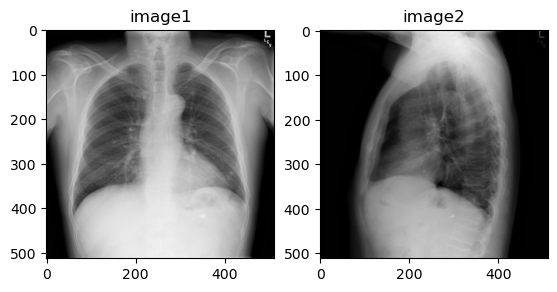

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3219_IM-1520-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3219_IM-1520-2001.png
blue:  (0.011481150414592464, 0.0214792656287113, 0.026577308427740337, 0.029378961489027678)
rouge:  0.08695651850451598
rouge_l:  0.08219178082191782
meteor:  0.03669724770642201
ACTUAL REPORT:  <sos> heart size within normal limits mild aortic ectasia tortuosity hyperinflated lungs with left perihilar and bibasilar opacities which may compatible with subsegmental atelectasis scarring otherwise no focal alveolar consolidation no definite pleural effusion seen no typical findings pulmonary edema dense nodules the left lung suggest previous granulomatous process right upper abdominal coiled artifacts question prior embolization procedure  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
**************************************

In [71]:
for i in range(5):
    i1 = cv2.imread(blue_min_five[i]["img1"])
    i2 = cv2.imread(blue_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", blue_min_five[i]["img1"]) 
    print("img2: ", blue_min_five[i]["img2"]) 
    print("blue: ", blue_min_five[i]["img_blue"]) 
    
    print("rouge: ", blue_min_five[i]["rouge"]) 
    print("rouge_l: ", blue_min_five[i]["rouge_l"]) 
    print("meteor: ", blue_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", blue_min_five[i]["actual"])
    print("GENERATED REPORT: ", blue_min_five[i]["generated"])


    print("*"*100)

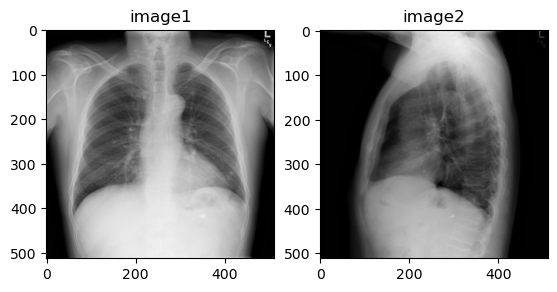

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3219_IM-1520-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3219_IM-1520-2001.png
blue:  (0.011481150414592464, 0.0214792656287113, 0.026577308427740337, 0.029378961489027678)
rouge:  0.08695651850451598
rouge_l:  0.08219178082191782
meteor:  0.03669724770642201
ACTUAL REPORT:  <sos> heart size within normal limits mild aortic ectasia tortuosity hyperinflated lungs with left perihilar and bibasilar opacities which may compatible with subsegmental atelectasis scarring otherwise no focal alveolar consolidation no definite pleural effusion seen no typical findings pulmonary edema dense nodules the left lung suggest previous granulomatous process right upper abdominal coiled artifacts question prior embolization procedure  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
**************************************

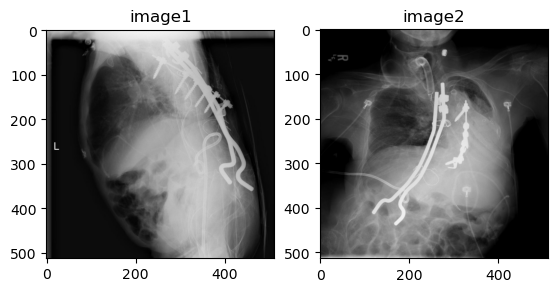

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-9001.png
blue:  (0.003924779761871609, 0.00847849331168295, 0.011016657168541341, 0.01246150158758297)
rouge:  0.08450703908748278
rouge_l:  0.07142857142857142
meteor:  0.023291925465838508
ACTUAL REPORT:  <sos> displacement fusion the lateral view with distal tip closely approximating the skin surface with change alignment since the previous exam severe scoliosis tracheostomy tube left picc tip the right hemithorax the expected location the right subclavian vein repositioning recommended heart size within normal limits for technique retrocardiac opacity due part atelectasis with small left hemithorax bronchovascular crowding without typical findings pulmonary edema shunt tubing and right nephrostomy tube  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atheroscleroti

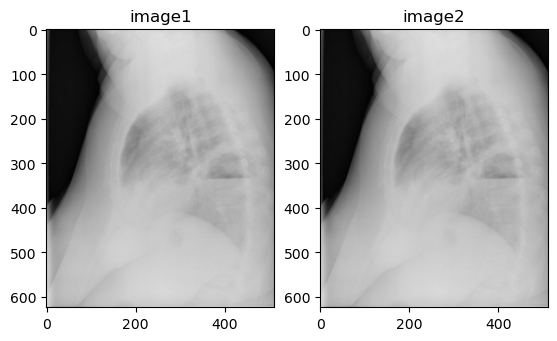

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
blue:  (0.036770734578938286, 0.09728621922103405, 0.13543097116981093, 0.1582434839611266)
rouge:  0.0930232514223907
rouge_l:  0.0851063829787234
meteor:  0.03215434083601286
ACTUAL REPORT:  <sos> airspace disease within the superior segment the right lower lobe with moderate layering right pleural effusion with air fluid level follow resolution cross sectional imaging the chest recommended rule out malignancy  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


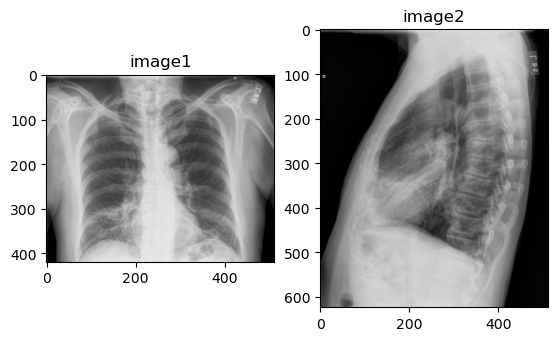

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-3003.png
blue:  (0.03423586234882512, 0.09057957769483091, 0.12609473647537955, 0.14733461804689552)
rouge:  0.08888888460246935
rouge_l:  0.08333333333333333
meteor:  0.03125
ACTUAL REPORT:  <sos> hyperexpanded lungs suggesting emphysema patchy right middle lobe airspace disease may represent pneumonia followup examination suggested following treatment confirm clearing the opacities post treatment interval film would reasonable allow clearing inflammatory opacities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


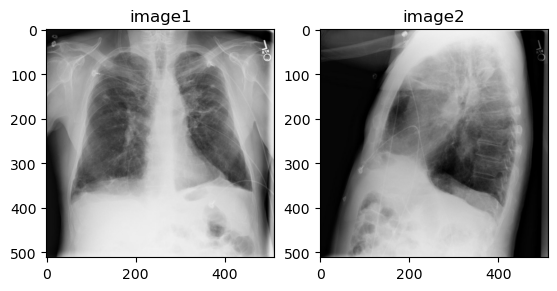

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-2001.png
blue:  (0.00602478423192258, 0.013015021456982204, 0.016911262905074057, 0.019129190126873696)
rouge:  0.09230768892781077
rouge_l:  0.0759493670886076
meteor:  0.02542372881355932
ACTUAL REPORT:  <sos> severe emphysema irregular pleural parenchymal opacity left upper lobe this may irregular pleural parenchymal scarring however recommend comparison with more remote outside imaging available determine long term stability none are available recommend short term months evaluation coronal and sagittal reformatted images from the outside study would also helpful these were not available the outside institution malignancy cannot confidently excluded the available images  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
***********

In [72]:
for i in range(5):
    i1 = cv2.imread(rouge_min_five[i]["img1"])
    i2 = cv2.imread(rouge_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", rouge_min_five[i]["img1"]) 
    print("img2: ", rouge_min_five[i]["img2"]) 
    print("blue: ", rouge_min_five[i]["img_blue"]) 
    
    print("rouge: ", rouge_min_five[i]["rouge"]) 
    print("rouge_l: ", rouge_min_five[i]["rouge_l"]) 
    print("meteor: ", rouge_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", rouge_min_five[i]["actual"])
    print("GENERATED REPORT: ", rouge_min_five[i]["generated"])


    print("*"*100)

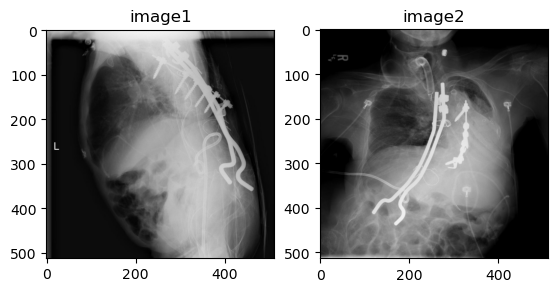

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1945_IM-0614-9001.png
blue:  (0.003924779761871609, 0.00847849331168295, 0.011016657168541341, 0.01246150158758297)
rouge:  0.08450703908748278
rouge_l:  0.07142857142857142
meteor:  0.023291925465838508
ACTUAL REPORT:  <sos> displacement fusion the lateral view with distal tip closely approximating the skin surface with change alignment since the previous exam severe scoliosis tracheostomy tube left picc tip the right hemithorax the expected location the right subclavian vein repositioning recommended heart size within normal limits for technique retrocardiac opacity due part atelectasis with small left hemithorax bronchovascular crowding without typical findings pulmonary edema shunt tubing and right nephrostomy tube  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atheroscleroti

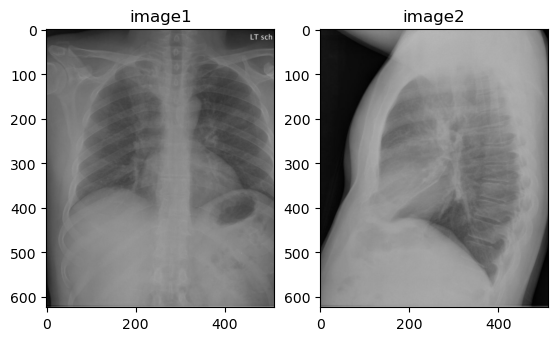

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1000_IM-0003-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1000_IM-0003-2001.png
blue:  (0.0318757371640614, 0.08433527339296575, 0.11740211584881308, 0.13717777902537298)
rouge:  0.095238090793651
rouge_l:  0.08163265306122448
meteor:  0.030395136778115506
ACTUAL REPORT:  <sos> increased opacity the right upper lobe with associated atelectasis may represent focal consolidation mass lesion with atelectasis recommend chest ct for further evaluation opacity overlying the left rib may represent focal airspace disease  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


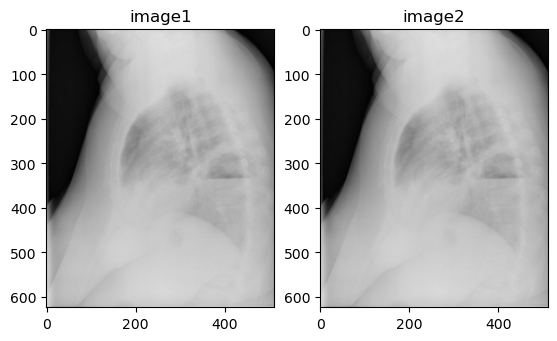

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3056_IM-1423-2001.png
blue:  (0.036770734578938286, 0.09728621922103405, 0.13543097116981093, 0.1582434839611266)
rouge:  0.0930232514223907
rouge_l:  0.0851063829787234
meteor:  0.03215434083601286
ACTUAL REPORT:  <sos> airspace disease within the superior segment the right lower lobe with moderate layering right pleural effusion with air fluid level follow resolution cross sectional imaging the chest recommended rule out malignancy  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


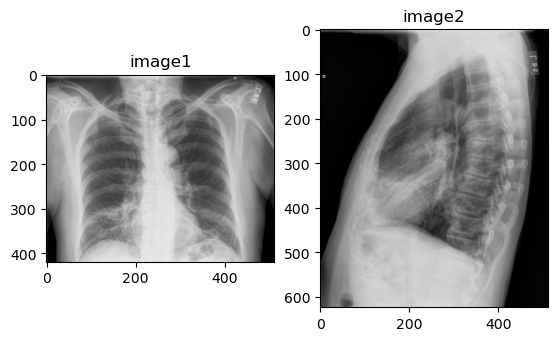

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3974_IM-2034-3003.png
blue:  (0.03423586234882512, 0.09057957769483091, 0.12609473647537955, 0.14733461804689552)
rouge:  0.08888888460246935
rouge_l:  0.08333333333333333
meteor:  0.03125
ACTUAL REPORT:  <sos> hyperexpanded lungs suggesting emphysema patchy right middle lobe airspace disease may represent pneumonia followup examination suggested following treatment confirm clearing the opacities post treatment interval film would reasonable allow clearing inflammatory opacities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


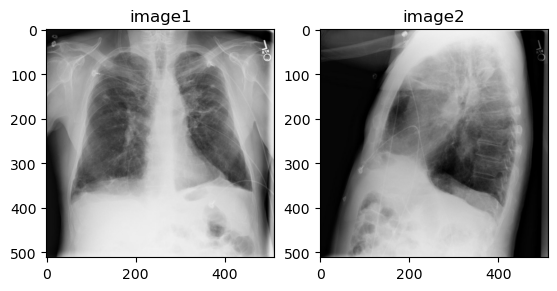

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1075_IM-0054-2001.png
blue:  (0.00602478423192258, 0.013015021456982204, 0.016911262905074057, 0.019129190126873696)
rouge:  0.09230768892781077
rouge_l:  0.0759493670886076
meteor:  0.02542372881355932
ACTUAL REPORT:  <sos> severe emphysema irregular pleural parenchymal opacity left upper lobe this may irregular pleural parenchymal scarring however recommend comparison with more remote outside imaging available determine long term stability none are available recommend short term months evaluation coronal and sagittal reformatted images from the outside study would also helpful these were not available the outside institution malignancy cannot confidently excluded the available images  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
***********

In [73]:
for i in range(5):
    i1 = cv2.imread(meteor_min_five[i]["img1"])
    i2 = cv2.imread(meteor_min_five[i]["img2"])
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("image2")
    plt.imshow(i2)
    plt.show()
    print("img1: ", meteor_min_five[i]["img1"]) 
    print("img2: ", meteor_min_five[i]["img2"]) 
    print("blue: ", meteor_min_five[i]["img_blue"]) 
    
    print("rouge: ", meteor_min_five[i]["rouge"]) 
    print("rouge_l: ", meteor_min_five[i]["rouge_l"]) 
    print("meteor: ", meteor_min_five[i]["meteor"]) 

    print("ACTUAL REPORT: ", meteor_min_five[i]["actual"])
    print("GENERATED REPORT: ", meteor_min_five[i]["generated"])


    print("*"*100)

1/1 [==============================] - 0s 19ms/step


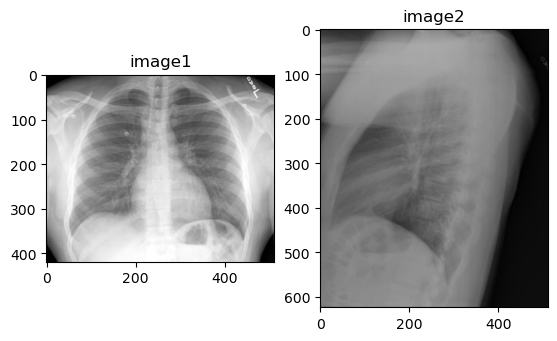

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR331_IM-1584-2001.png
blue:  (0.3571428571428572, 0.2870846258816073, 0.24293866735461883, 0.18798317647335086)
rouge:  0.49999999580000004
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [74]:
i=3
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 23ms/step


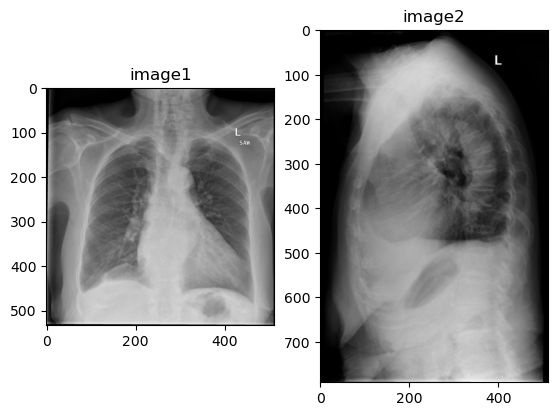

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR666_IM-2241-1002.png
blue:  (0.42857142857142855, 0.1815682598006407, 0.3243144912732185, 0.42610827239170174)
rouge:  0.31999999507200005
rouge_l:  0.32
meteor:  0.37733529990167164
ACTUAL REPORT:  <sos> borderline cardiomegaly and mild chronic changes no acute infiltrate  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [75]:
i=536
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 19ms/step


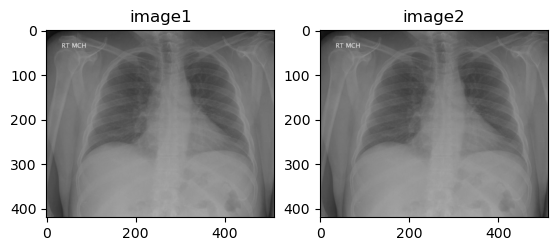

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1120_IM-0080-1001.png
blue:  (0.42857142857142855, 0.3144854510165755, 0.2580040100182615, 0.19674979811155635)
rouge:  0.4615384565680473
rouge_l:  0.4615384615384615
meteor:  0.46106557377049184
ACTUAL REPORT:  <sos> limited low lung volume exam otherwise no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [76]:
i=541
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


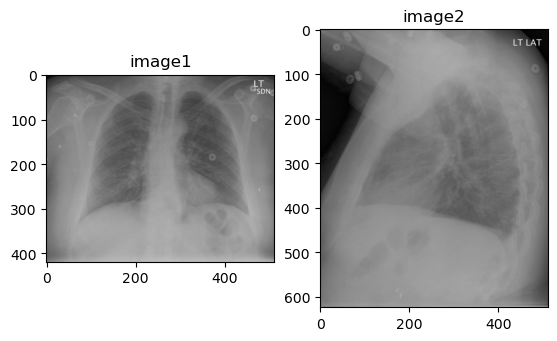

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3526_IM-1723-2001.png
blue:  (0.2857142857142857, 0.14824986333222023, 0.2836979771131725, 0.38503228868787126)
rouge:  0.33333332847222225
rouge_l:  0.3333333333333333
meteor:  0.3034855769230769
ACTUAL REPORT:  <sos> low lung volumes without evidence acute cardiopulmonary process  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [77]:
i=562
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 19ms/step


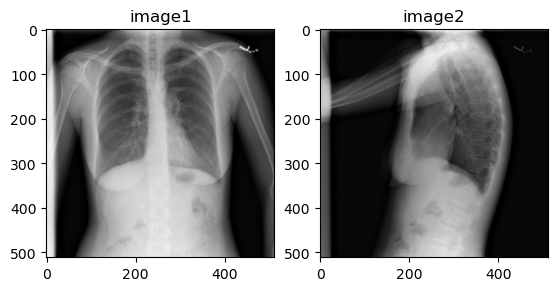

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3658_IM-1819-2001.png
blue:  (0.07511257491796854, 0.19872919356665253, 0.27664851096100623, 0.3232482483806194)
rouge:  0.11111110635802489
rouge_l:  0.1081081081081081
meteor:  0.04524886877828054
ACTUAL REPORT:  <sos> buckling deformity the anterior cortex the body fracture possible high energy was localized this region correlate with focal tenderness chest warranted  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [78]:
i=451
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 21ms/step


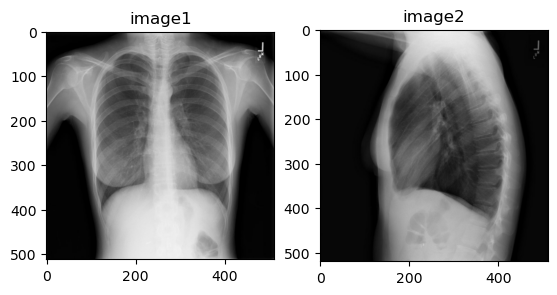

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR333_IM-1594-2001.png
blue:  (0.3571428571428572, 0.23440361546924776, 0.1690622446251985, 0.2601278440403792)
rouge:  0.49999999580000004
rouge_l:  0.5
meteor:  0.6558823529411765
ACTUAL REPORT:  <sos> no acute pulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [79]:
i=1
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 19ms/step


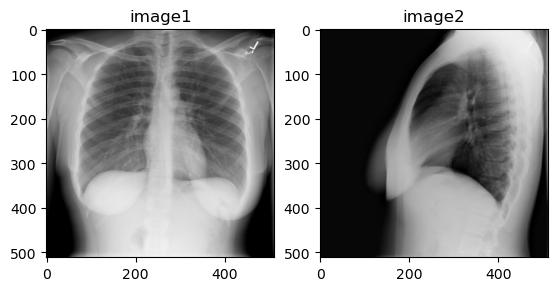

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR893_IM-2403-2001.png
blue:  (0.12124938447912854, 0.22683682753906254, 0.2806759054284071, 0.310263420349682)
rouge:  0.15789473218836578
rouge_l:  0.15
meteor:  0.08064516129032259
ACTUAL REPORT:  <sos> the heart size and cardiomediastinal silhouette are within normal limits pulmonary vasculature appears normal there no focal air space consolidation no pleural effusion pneumothorax  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [80]:
i=136
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

In [81]:
i=12
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 20ms/step


img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3304_IM-1581-2001.png
blue:  (0.3571428571428572, 0.2870846258816073, 0.24293866735461883, 0.18798317647335086)
rouge:  0.49999999580000004
rouge_l:  0.5
meteor:  0.7117647058823529
ACTUAL REPORT:  <sos> no acute cardiopulmonary disease  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


1/1 [==============================] - 0s 40ms/step


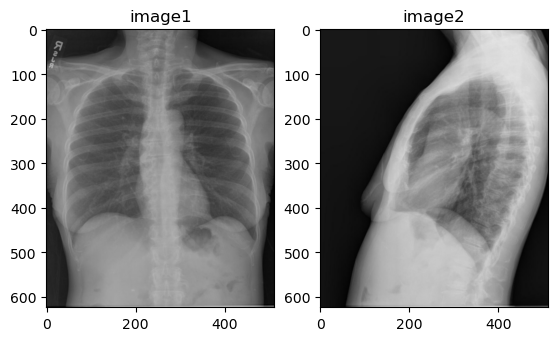

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3319_IM-1588-2001.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.571428566984127
rouge_l:  0.5714285714285714
meteor:  0.7647907647907648
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality identified  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [82]:
i=145
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 18ms/step


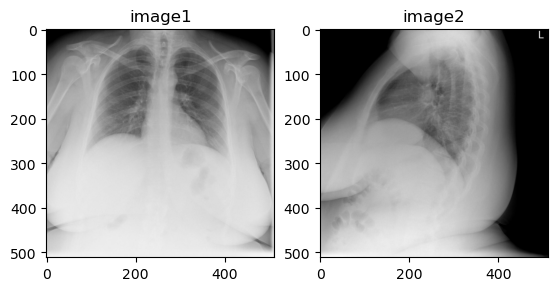

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR114_IM-0096-2001.png
blue:  (0.3571428571428572, 0.2870846258816073, 0.24293866735461883, 0.18798317647335086)
rouge:  0.49999999580000004
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormalities  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [83]:
i=179
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 21ms/step


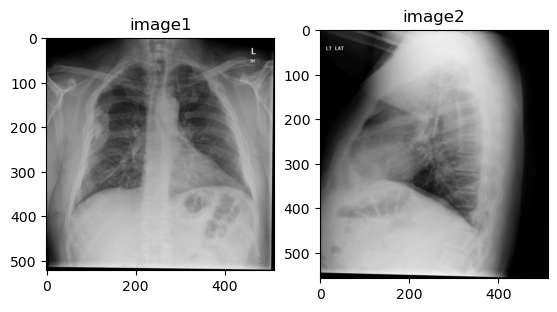

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3408_IM-1648-1002.png
blue:  (0.42857142857142855, 0.36313651960128146, 0.3243144912732185, 0.27824623288353134)
rouge:  0.5999999958
rouge_l:  0.6
meteor:  0.866013071895425
ACTUAL REPORT:  <sos> no acute cardiopulmonary abnormality  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [84]:
i=180
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 19ms/step


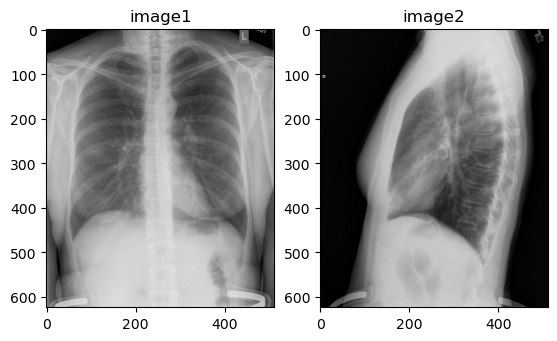

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-2002.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3499_IM-1703-3003.png
blue:  (0.37225089001774603, 0.23656131208416648, 0.18481194283407207, 0.13772816872553614)
rouge:  0.4117647010380623
rouge_l:  0.4117647058823529
meteor:  0.36203286082474223
ACTUAL REPORT:  <sos> comparison well expanded and clear lungs mediastinal contour within normal limits no acute cardiopulmonary abnormality identified stable chest  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [85]:
i=181
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 19ms/step


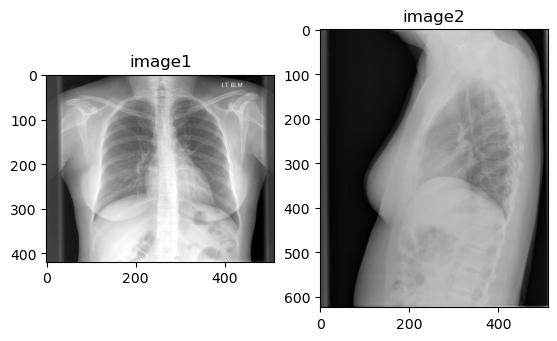

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR3763_IM-1883-2001.png
blue:  (0.21428571428571425, 0.12838814775327384, 0.2580040100182615, 0.35831291876413535)
rouge:  0.3157894698060942
rouge_l:  0.3157894736842105
meteor:  0.4331450094161958
ACTUAL REPORT:  <sos> no active disease  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [86]:
i=182
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

In [87]:
i=188
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

1/1 [==============================] - 0s 22ms/step


img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR1330_IM-0213-2001.png
blue:  (0.2857142857142857, 0.14824986333222023, 0.2836979771131725, 0.38503228868787126)
rouge:  0.3809523765079365
rouge_l:  0.38095238095238093
meteor:  0.40990259740259744
ACTUAL REPORT:  <sos> negative for acute cardiopulmonary findings  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


1/1 [==============================] - 0s 20ms/step


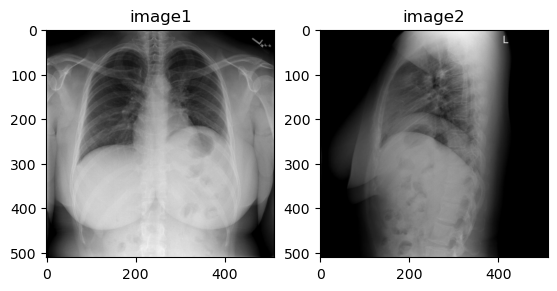

img1:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-1001.png
img2:  /kaggle/input/fyp2-dataset/NLMCXR_png/NLMCXR_png/CXR2117_IM-0745-2001.png
blue:  (0.10510841176326924, 0.1966398326430567, 0.24331173940825815, 0.26896050220204015)
rouge:  0.19512194672218927
rouge_l:  0.19047619047619047
meteor:  0.07518796992481203
ACTUAL REPORT:  <sos> stable appearance chest without active process evident and without evidence progression disease patient with history hodgkin lymphoma one would like discuss this case further please thanks  <eos>
GENERATED REPORT:  <sos> no acute cardiopulmonary abnormality stable cardiomegaly tortuous thoracic aorta and atherosclerotic calcification <eos> 
****************************************************************************************************


In [88]:
i=481
img1=root_path+test.iloc[i]["image_1"]
img2=root_path+test.iloc[i]["image_2"]
  
result=evaluate(img1,img2) 
actual=test_report[i]
img_blue = get_bleu(actual,result)
rouge = get_rouge(actual,result)
meteor = get_meteor(actual,result)
rouge_l = get_rouge_l(actual,result)

i1 = cv2.imread(img1)
i2 = cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()

print("img1: ", img1) 
print("img2: ", img2) 
print("blue: ", img_blue) 
print("rouge: ", rouge) 
print("rouge_l: ", rouge_l) 
print("meteor: ", meteor) 
print("ACTUAL REPORT: ", actual)
print("GENERATED REPORT: ", result)


print("*"*100)

In [89]:
distinct_count = df['Result'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 1


In [90]:
distinct_count = df['Actual'].nunique()

# Print the distinct count
print("Distinct Result count :", distinct_count)

Distinct Result count : 391


In [91]:
import os
os.makedirs('/kaggle/output/', exist_ok=True)

In [92]:
import shutil

In [94]:
output_file_path = "/kaggle/working/chexImpressionBiobertATT.h5"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

'/kaggle/output/chexImpressionBiobertATT.h5'

In [95]:
output_file_path = "/kaggle/working/results.csv"
destination_dir = "/kaggle/output/"
shutil.copy(output_file_path, destination_dir)

'/kaggle/output/results.csv'